In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


2025-07-12 18:30:53.111115: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    './MLProject/split_data/train',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    './MLProject/split_data/val',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

test_gen = datagen.flow_from_directory(
    './MLProject/split_data/test',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # important for later confusion matrix
)


Found 3319 images belonging to 9 classes.
Found 716 images belonging to 9 classes.
Found 717 images belonging to 9 classes.


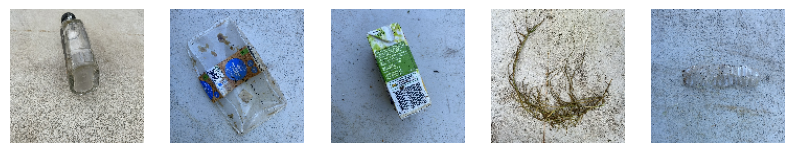

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# grab a batch
x_batch, y_batch = next(train_gen)

# plot first 5 images
plt.figure(figsize=(10,5))
for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()


### Trying to augment data

In [4]:
# Training data generator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    './MLProject/split_data/train',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

# Validation and test data generators (only rescaling)
test_val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = test_val_datagen.flow_from_directory(
    './MLProject/split_data/val',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_val_datagen.flow_from_directory(
    './MLProject/split_data/test',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 3319 images belonging to 9 classes.
Found 716 images belonging to 9 classes.
Found 717 images belonging to 9 classes.


In [ ]:
x_batch, y_batch = next(train_gen)

# plot first 5 images
plt.figure(figsize=(10,5))
for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()

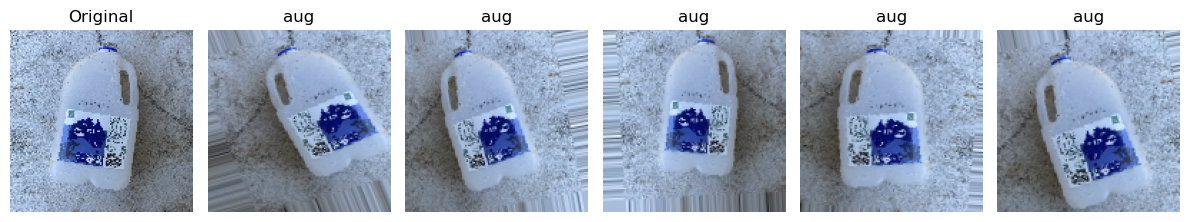

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Your specific image path
img_path = "./MLProject/split_data/train/Plastic/Plastic_2.jpg"

# Load the original image and resize to your target size
original_img = load_img(img_path, target_size=(128,128))
original_array = img_to_array(original_img) / 255.0  # normalize

# Create a single image batch for augmentation
single_image = np.expand_dims(img_to_array(original_img), axis=0)

# Use your datagen to create an iterator that will augment this single image
aug_iter = datagen.flow(single_image, batch_size=1)

# Plot original + several augmented versions
plt.figure(figsize=(12,4))

# Plot original
plt.subplot(1,6,1)
plt.imshow(original_array)
plt.title('Original')
plt.axis('off')

# Plot 5 augmented versions
for i in range(5):
    augmented_img = next(aug_iter)[0] 
    ax = plt.subplot(1,6,i+2)
    plt.imshow(augmented_img)
    plt.title('aug')
    plt.axis('off')
    print(aug_iter)
plt.tight_layout()
plt.show()


In [5]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])


In [6]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,801 (12.61 MB)

 Trainable params: 3,305,801 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [8]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)


/home/crowley/miniforge3/envs/MLP/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 69s 651ms/step - accuracy: 0.1901 - loss: 2.1371 - val_accuracy: 0.3226 - val_loss: 1.7508
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 63s 601ms/step - accuracy: 0.3453 - loss: 1.7593 - val_accuracy: 0.4078 - val_loss: 1.5661
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 62s 595ms/step - accuracy: 0.3979 - loss: 1.6591 - val_accuracy: 0.4120 - val_loss: 1.5443
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 63s 605ms/step - accuracy: 0.4178 - loss: 1.5933 - val_accuracy: 0.4651 - val_loss: 1.5860
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 63s 604ms/step - accuracy: 0.4169 - loss: 1.5466 - val_accuracy: 0.5000 - val_loss: 1.4072
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 63s 604ms/step - accuracy: 0.4576 - loss: 1.4700 - val_accuracy: 0.4874 - val_loss: 1.4776
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 62s 593ms/step - accuracy: 0.4664 - loss: 1.4655 - val_accuracy: 0.5182 - val_loss: 1.3658
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 61s 590ms/step - accuracy: 0.4981 - loss: 1

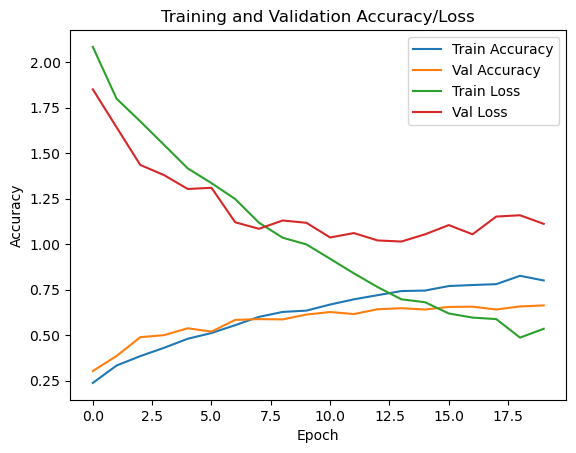

In [8]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Accuracy/Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [9]:
loss, acc = model.evaluate(test_gen)
print(f"Test accuracy: {acc*100:.2f}%")


/home/crowley/miniforge3/envs/MLP/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.6369 - loss: 1.2352
Test accuracy: 65.13%


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step


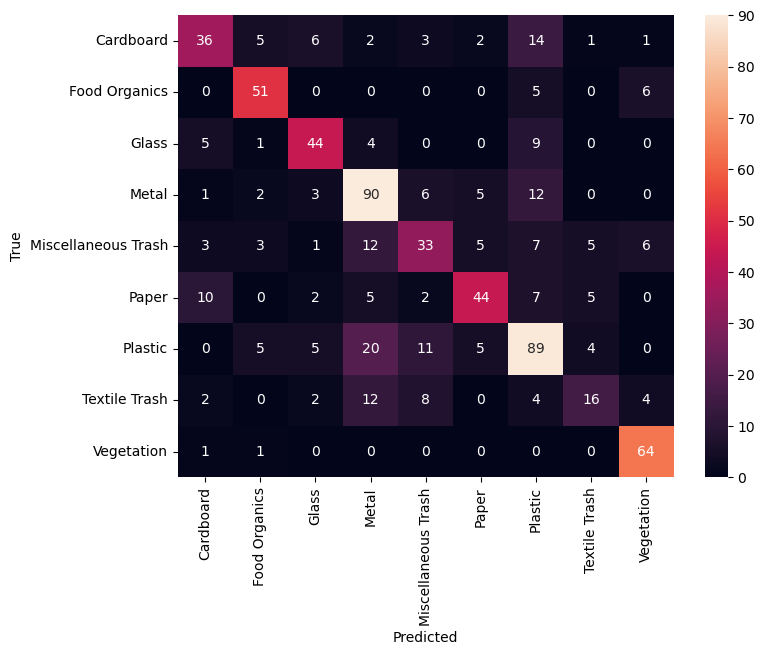

                     precision    recall  f1-score   support

          Cardboard       0.62      0.51      0.56        70
      Food Organics       0.75      0.82      0.78        62
              Glass       0.70      0.70      0.70        63
              Metal       0.62      0.76      0.68       119
Miscellaneous Trash       0.52      0.44      0.48        75
              Paper       0.72      0.59      0.65        75
            Plastic       0.61      0.64      0.62       139
      Textile Trash       0.52      0.33      0.41        48
         Vegetation       0.79      0.97      0.87        66

           accuracy                           0.65       717
          macro avg       0.65      0.64      0.64       717
       weighted avg       0.64      0.65      0.64       717



In [10]:
# Get predictions
pred_probs = model.predict(test_gen)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_gen.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=test_gen.class_indices.keys(), 
            yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Detailed metrics
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))
